STATISTICS PROJECT

In [1]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

DATASET DESCRIPTION

 The File “housing.csv” is a dataset regarding housing prices in Melbourne, collected at 2017. It contains the
 housing prices, as well as many variables that may help estimate the housing prices. The list of variables,
 as well as there descriptions, are detailed as follows.

• Rooms: Number of rooms

• Price: Price in dollars

• Method: S- property sold; SP- property sold prior; PI- property passed in; PN- sold prior not
 disclosed; SN- sold not disclosed; NB- no bid; VB- vendor bid; W- withdrawn prior to auction; SA
sold after auction; SS- sold after auction price not disclosed. N/A- price or highest bid not available.

• Type: br- bedroom(s); h- house,cottage,villa, semi,terrace; u- unit, duplex; t- townhouse; dev site
development site; o res- other residential.

• SellerG: Real Estate Agent

• Date: Date sold

• Distance: Distance from CBD

• Regionname: General Region (West, North West, North, North east ...etc)

• Propertycount: Number of properties that exist in the suburb.

• Bathroom: Number of Bathrooms

• Bedroom2 : Scraped Number of Bedrooms (from different source)

• Car: Number of carspots

• Landsize: Land Size

• BuildingArea: Building Size

• CouncilArea: Governing council for the area


In [2]:
df = pd.read_csv('../data/housing.csv')
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


To keep the future models more simple we decided to use only some of the available columns for the dataset, specifically we decided not to use the column 'Method' since it adds complexity to the model that may be difficcult to interpret in the future models, as well as the column 'SellerG' because we are not interested in the real estate agent that sold the house, the column 'Distance' because of its general description that is harder to interpret, 'CouncilArea' because we wanted to focus more on the general location with 'Regionname' and 'Date' because the datetime format makes it so that the final model will have a lot of categories.

In [3]:
df = df[['Rooms', 'Type', 'Price', 'Propertycount', 'Bathroom', 'Bedroom2', 'Car', 'Landsize', 'BuildingArea', 'Regionname','YearBuilt', 'Lattitude', 'Longtitude']]

df['YearBuilt'] = df['YearBuilt'].replace(np.nan, df['YearBuilt'].median())
df.head()

,Rooms,Type,Price,Propertycount,Bathroom,Bedroom2,Car,Landsize,BuildingArea,Regionname,YearBuilt,Lattitude,Longtitude
0,2,h,1480000.0,4019.0,1.0,2.0,1.0,202.0,NaN,Northern Metropolitan,1970.0,-37.7996,144.9984
1,2,h,1035000.0,4019.0,1.0,2.0,0.0,156.0,79.0,Northern Metropolitan,1900.0,-37.8079,144.9934
2,3,h,1465000.0,4019.0,2.0,3.0,0.0,134.0,150.0,Northern Metropolitan,1900.0,-37.8093,144.9944
3,3,h,850000.0,4019.0,2.0,3.0,1.0,94.0,NaN,Northern Metropolitan,1970.0,-37.7969,144.9969
4,4,h,1600000.0,4019.0,1.0,3.0,2.0,120.0,142.0,Northern Metropolitan,2014.0,-37.8072,144.9941


In [4]:
#number of rows
df.shape[0]

13580

In [5]:
#chech for missign values in the dataset
print(df.isnull().sum())

Rooms               0
Type                0
Price               0
Propertycount       0
Bathroom            0
Bedroom2            0
Car                62
Landsize            0
BuildingArea     6450
Regionname          0
YearBuilt           0
Lattitude           0
Longtitude          0
dtype: int64


The column BuildingArea has 6450 missing values, since we want to understand whether dropping rows with missing values will not bias the dataset, we run a descrptive analysis on the missing data.

In [6]:
missing = df[df['BuildingArea'].isnull()]
non_missing = df[df['BuildingArea'].notnull()]
print(missing.describe())
print(non_missing.describe())

             Rooms         Price  Propertycount     Bathroom     Bedroom2  \
count  6450.000000  6.450000e+03    6450.000000  6450.000000  6450.000000   
mean      2.894419  1.070999e+06    7479.506047     1.461705     2.875039   
std       0.936758  5.977844e+05    4415.657798     0.650994     0.958697   
min       1.000000  8.500000e+04     249.000000     0.000000     0.000000   
25%       2.000000  6.650000e+05    4380.000000     1.000000     2.000000   
50%       3.000000  9.170000e+05    6543.000000     1.000000     3.000000   
75%       3.000000  1.325000e+06   10331.000000     2.000000     3.000000   
max      10.000000  5.800000e+06   21650.000000     8.000000    20.000000   

               Car       Landsize  BuildingArea    YearBuilt    Lattitude  \
count  6417.000000    6450.000000           0.0  6450.000000  6450.000000   
mean      1.608851     633.526202           NaN  1969.393178   -37.810478   
std       0.981612    5685.271415           NaN    15.595985     0.078291  

The distribution of missing values in 'BuildingSize' seems to be random, but there is a noticible difference in the 'Landsize' of the two groups, we decided to run more tests.

<Axes: xlabel='Landsize', ylabel='Density'>

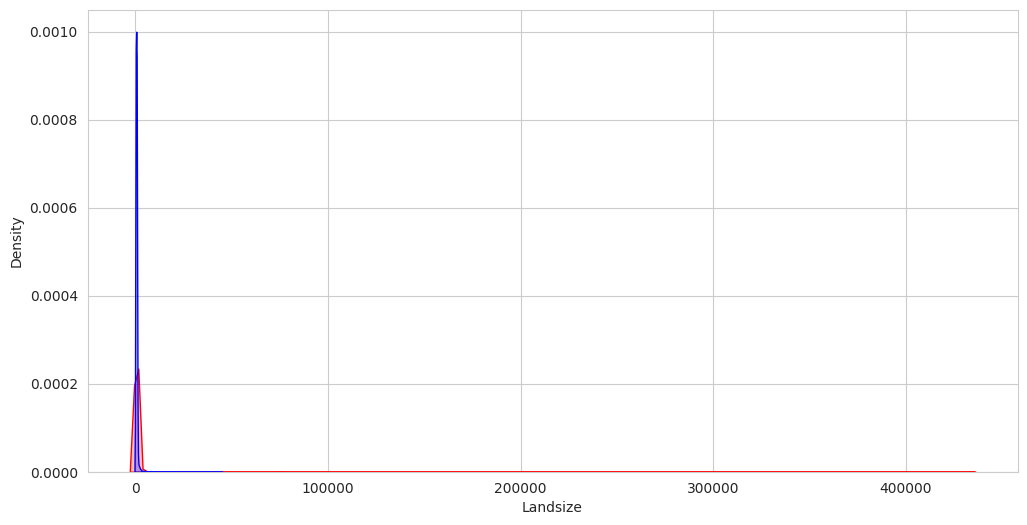

In [7]:
plt.figure(figsize=(12, 6))

sns.kdeplot(missing['Landsize'], label='Missing Building Area', shade=True, color='red')
sns.kdeplot(non_missing['Landsize'], label='Non-Missing Building Area', shade=True, color='blue')


Since the visualization is too broad, we took values < 100000

<Axes: xlabel='Landsize', ylabel='Density'>

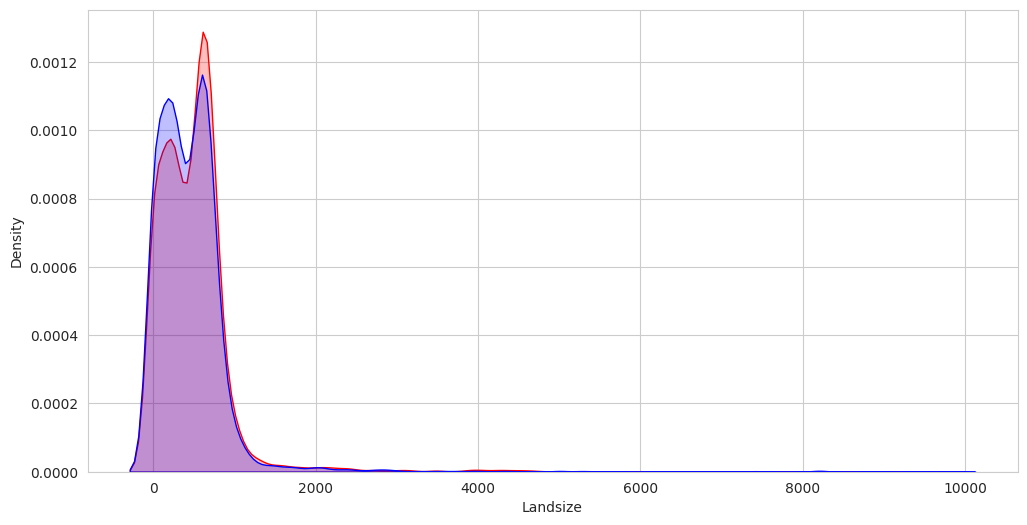

In [8]:
missing = missing[(missing.Landsize < 10000)]
non_missing = non_missing[(non_missing.Landsize < 10000)]

plt.figure(figsize=(12, 6))

sns.kdeplot(missing['Landsize'], label='Missing Building Area', shade=True, color='red')
sns.kdeplot(non_missing['Landsize'], label='Non-Missing Building Area', shade=True, color='blue')


After visualizing the distributions we can say that the the missing values seem to be random, we then decided to fill those out with the mean value of 'BuildingSize'.

The last variable that seems to have missing values is 'Car', at 62, the number of missing values is really low in the more than 13,000 rows of the dataset, so we dropped this missing values too.

There isn't any noticeble difference between the two groups, only a slight difference in the BuildingArea, but that could be explained by the need of having the specific council mentioned if the house is small, maybe to make it more interesting to the eyes of possible buyers.

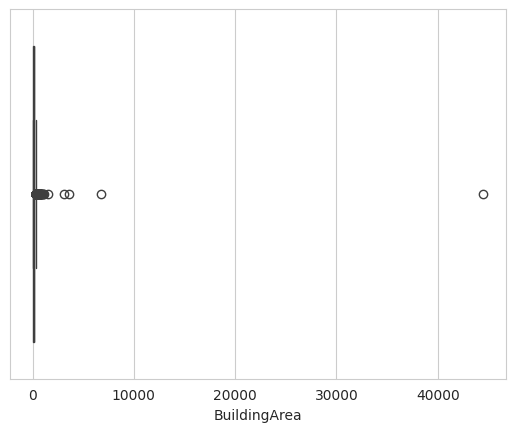

In [9]:
sns.boxplot(x = 'BuildingArea', data = df)
plt.show()

There are large outliers in the BuildingArea variables, so we decided to drop some of them from the dataset, we took values < 500

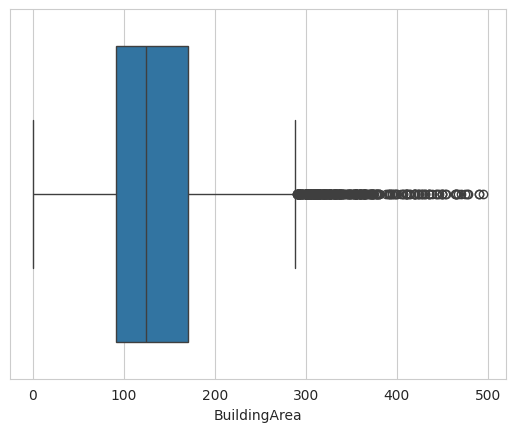

In [10]:
df = df[(df.BuildingArea < 500) | (df['BuildingArea'].isna())]
sns.boxplot(x = 'BuildingArea', data = df)
plt.show()

In [11]:
df['BuildingArea'] = df['BuildingArea'].fillna(df['BuildingArea'].mean())
print(df.isnull().sum())

Rooms             0
Type              0
Price             0
Propertycount     0
Bathroom          0
Bedroom2          0
Car              62
Landsize          0
BuildingArea      0
Regionname        0
YearBuilt         0
Lattitude         0
Longtitude        0
dtype: int64


In [12]:
df = df.dropna()
df.shape[0]

13454

After dealing with missing values we analyzed the distributions of the numerical explanatory variables in our dataset to check for outliers.

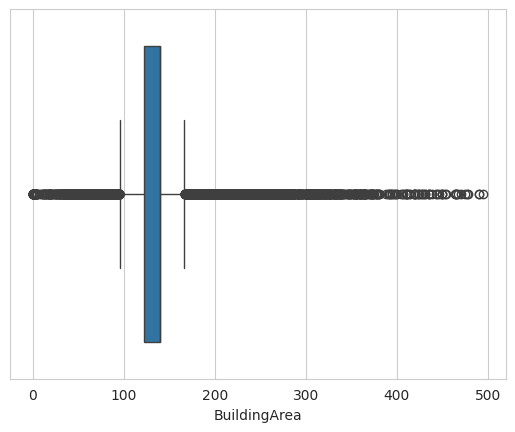

In [13]:
sns.boxplot(x = 'BuildingArea', data = df)
plt.show()

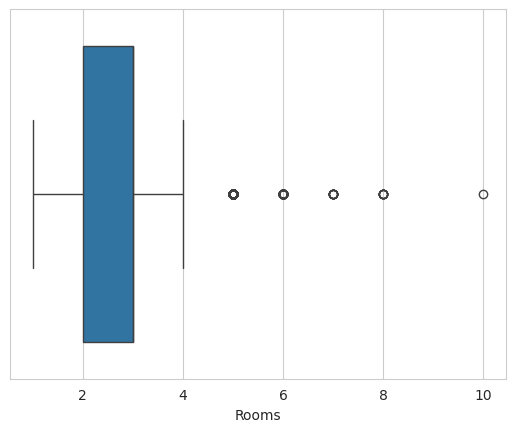

In [14]:
sns.boxplot(x = 'Rooms', data = df)
plt.show()

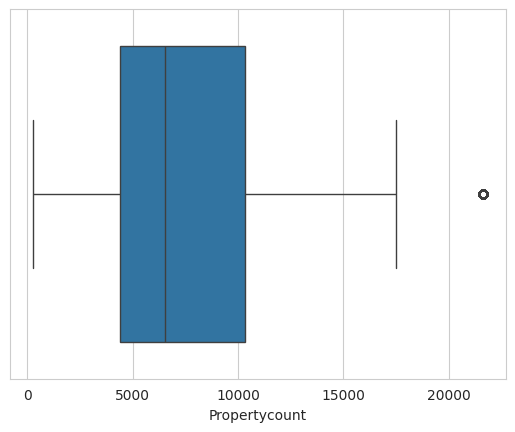

In [15]:
sns.boxplot(x = 'Propertycount', data = df)
plt.show()

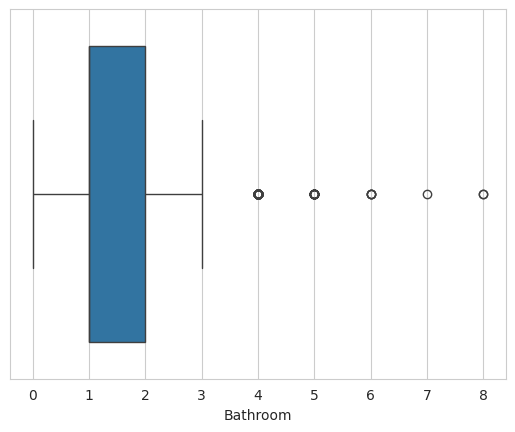

In [16]:
sns.boxplot(x = 'Bathroom', data = df)
plt.show()

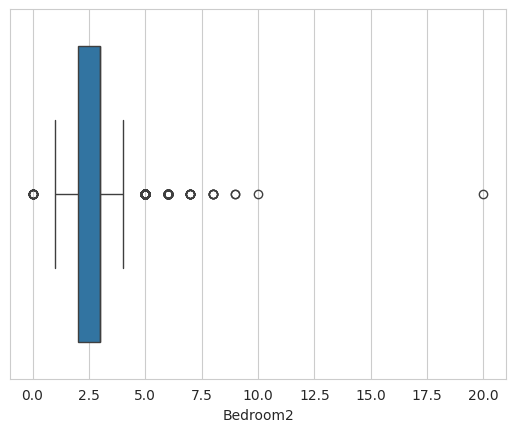

In [17]:
sns.boxplot(x = 'Bedroom2', data = df)
plt.show()

From the variables Bedroom2 we took values < 11

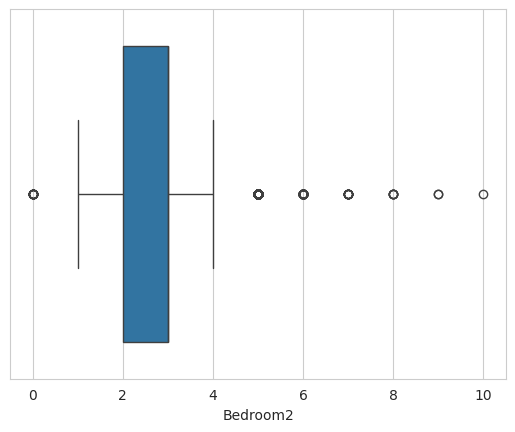

In [18]:
df = df[(df.Bedroom2 < 11)]
sns.boxplot(x = 'Bedroom2', data = df)
plt.show()

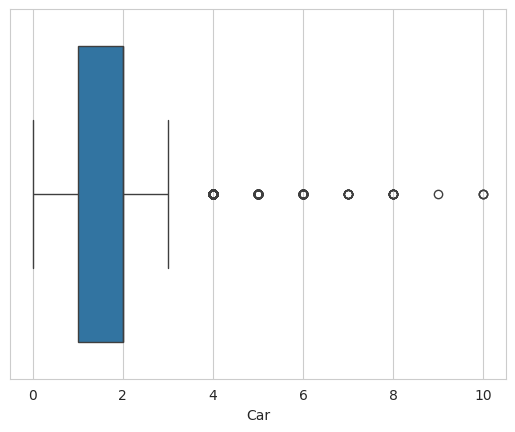

In [19]:
sns.boxplot(x = 'Car', data = df)
plt.show()

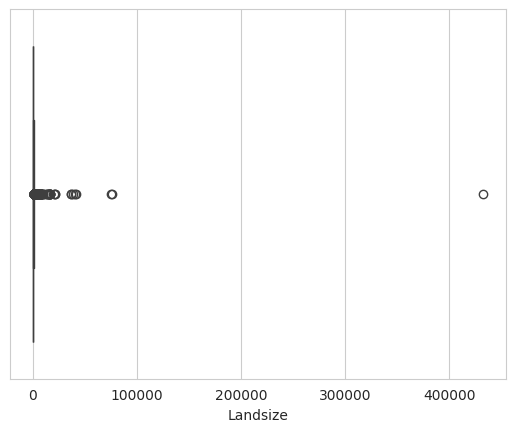

In [20]:
sns.boxplot(x = 'Landsize', data = df)
plt.show()

From the variables Landsize we took values < 20000.

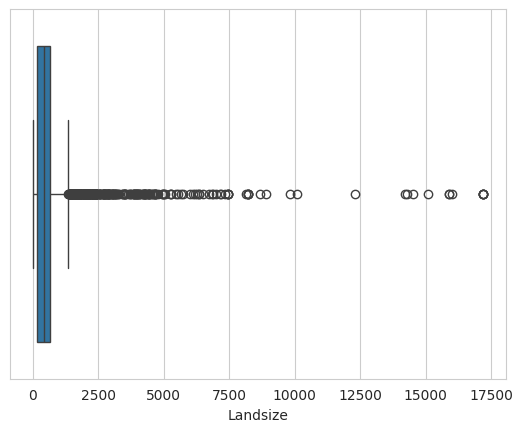

In [21]:
df = df[(df.Landsize < 20000)]
sns.boxplot(x = 'Landsize', data = df)
plt.show()

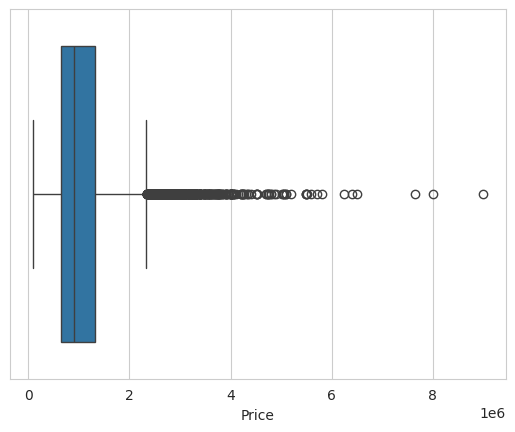

In [22]:
sns.boxplot(x = 'Price', data = df)
plt.show()

The variable Price will be our response variable when building models.

The first thing we want to do is analyze the associations and correlations between explanatory variables. We do so by using scatterplots for every pair of numerical explanatory variables and computing the correlation coefficients.

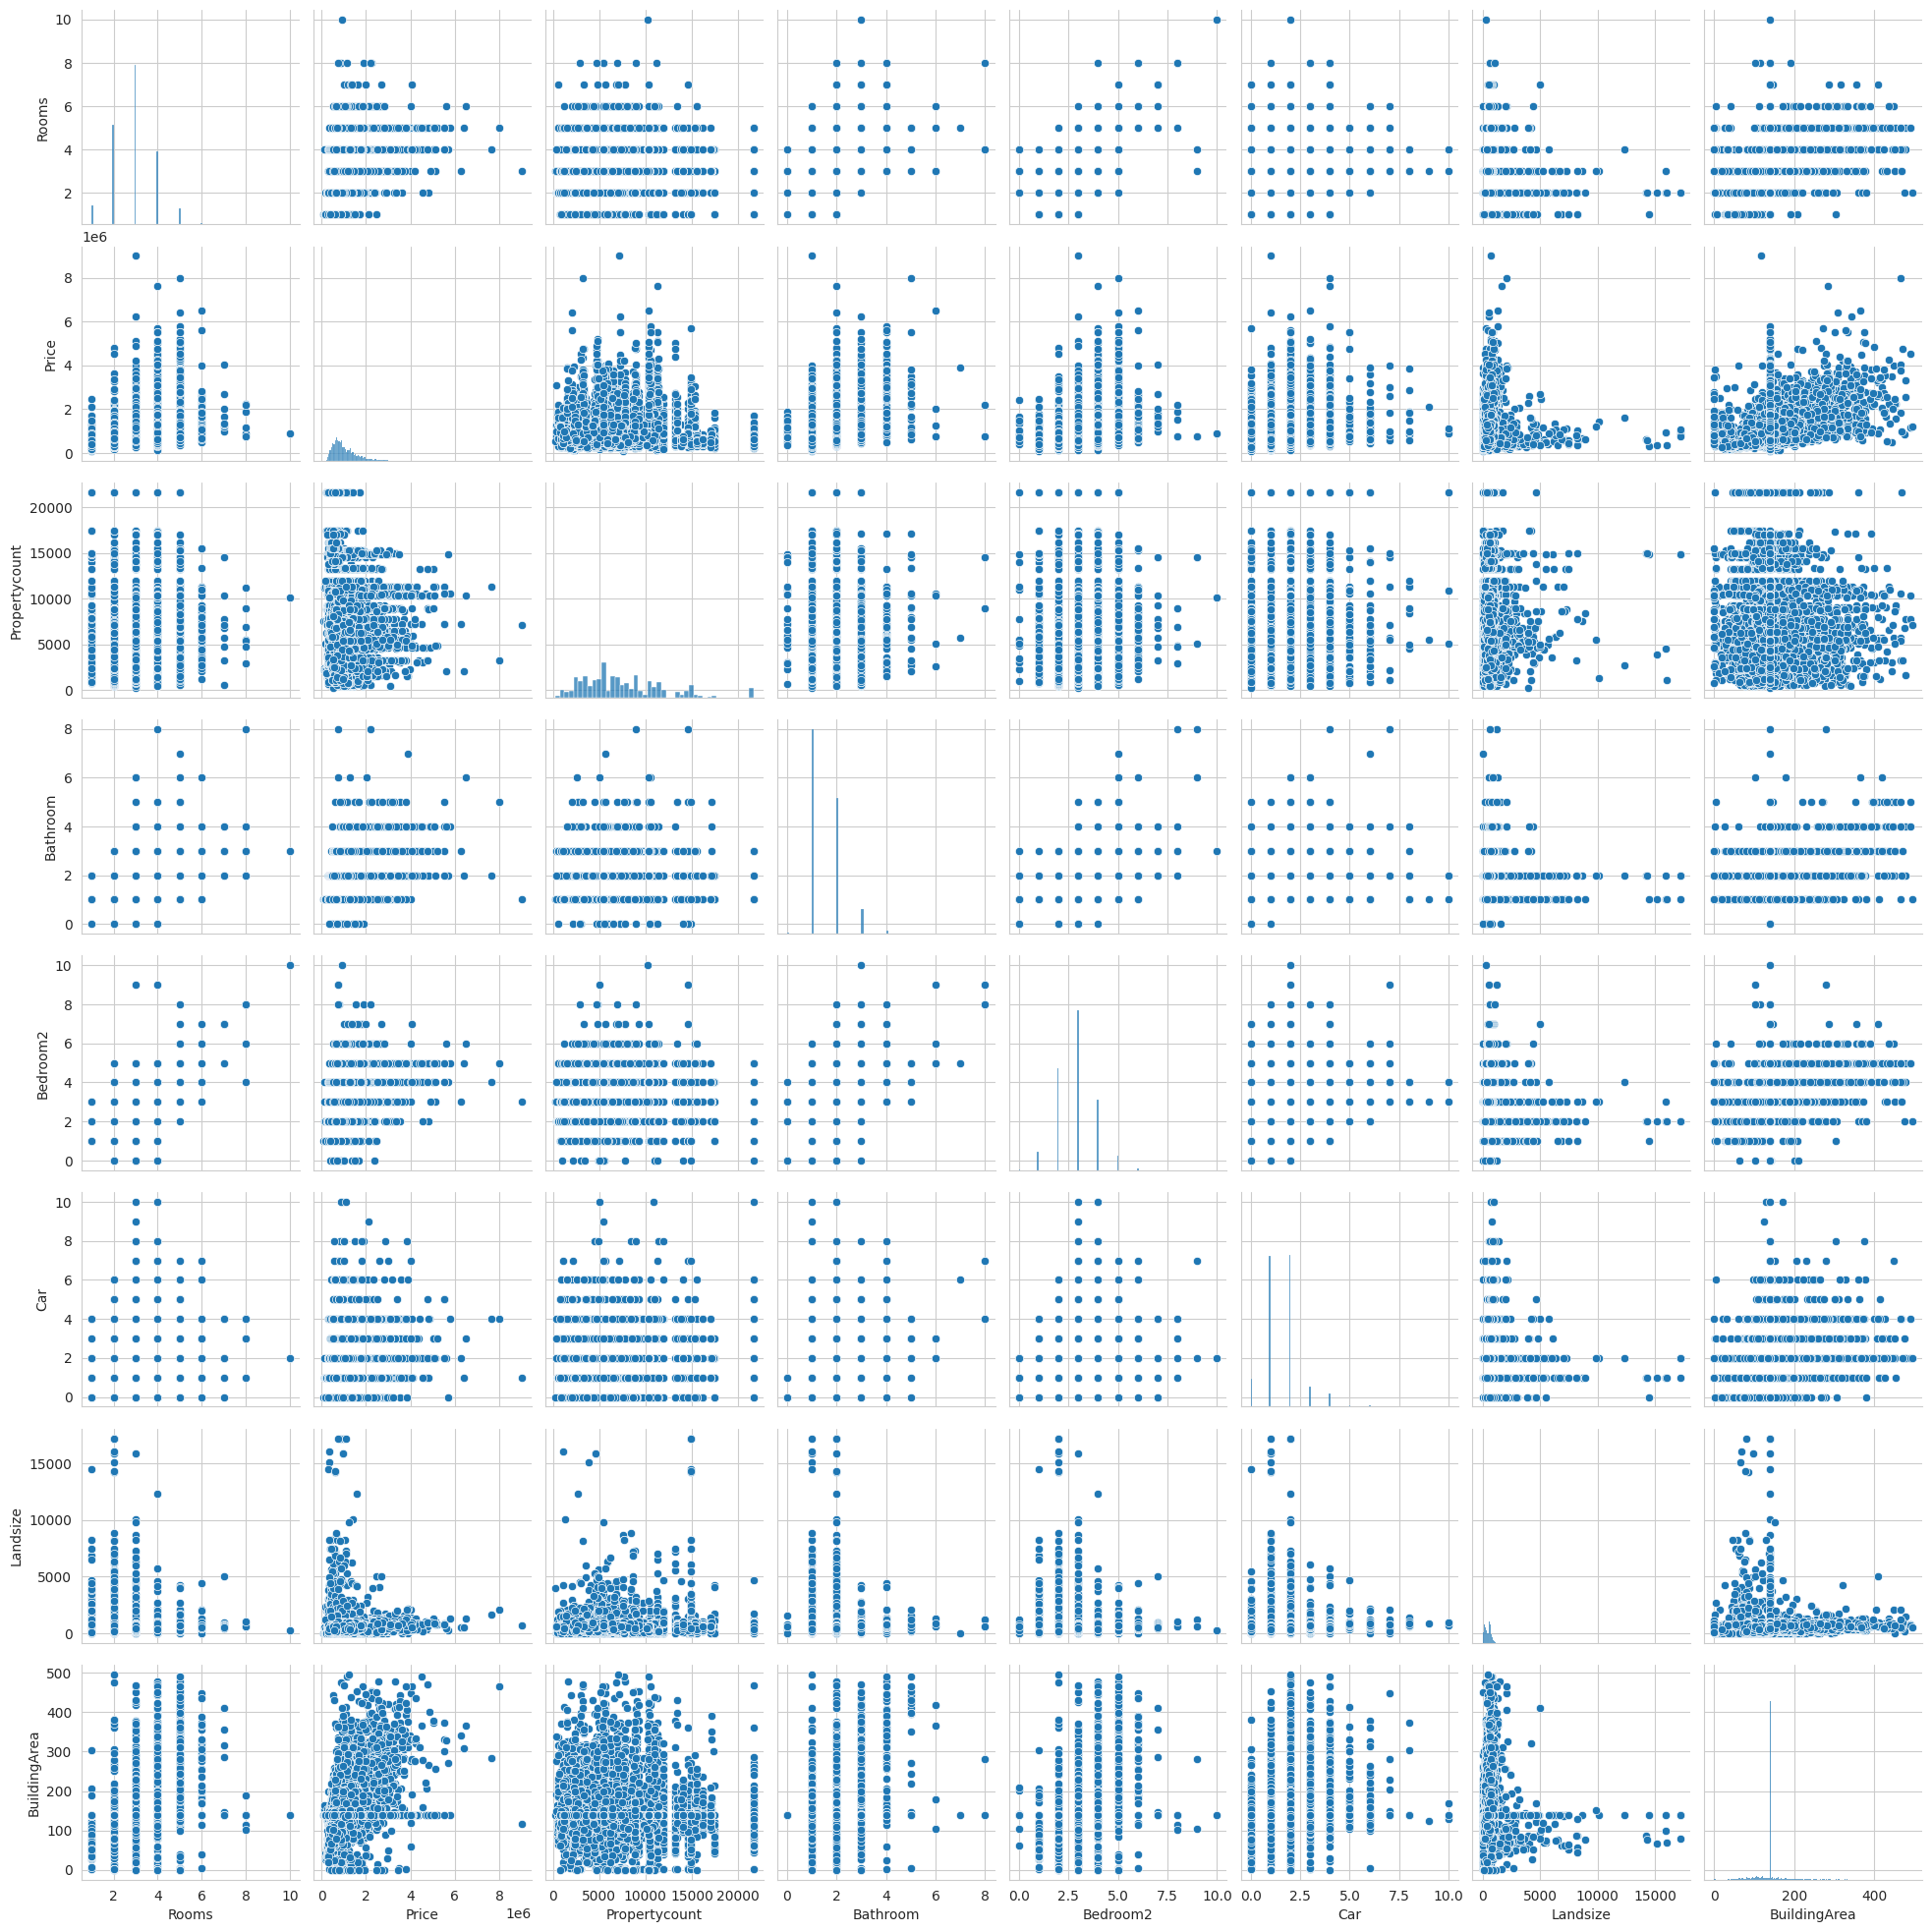

In [23]:
sns.pairplot(df[['Rooms', 'Price', 'Propertycount', 'Bathroom', 'Bedroom2', 'Car', 'Landsize','BuildingArea']])
plt.show()

In [24]:
df[['Rooms', 'Price', 'Propertycount', 'Bathroom', 'Bedroom2', 'Car', 'Landsize','BuildingArea']].corr()

,Rooms,Price,Propertycount,Bathroom,Bedroom2,Car,Landsize,BuildingArea
Rooms,1.000000,0.494700,-0.081640,0.590391,0.955250,0.406877,0.126308,0.516058
Price,0.494700,1.000000,-0.041415,0.463603,0.479347,0.236946,0.090597,0.466389
Propertycount,-0.081640,-0.041415,1.000000,-0.050772,-0.080094,-0.024155,-0.000658,-0.062715
Bathroom,0.590391,0.463603,-0.050772,1.000000,0.590305,0.320959,0.085842,0.485299
Bedroom2,0.955250,0.479347,-0.080094,0.590305,1.000000,0.407830,0.124971,0.506312
Car,0.406877,0.236946,-0.024155,0.320959,0.407830,1.000000,0.133814,0.273559
Landsize,0.126308,0.090597,-0.000658,0.085842,0.124971,0.133814,1.000000,0.090187
BuildingArea,0.516058,0.466389,-0.062715,0.485299,0.506312,0.273559,0.090187,1.000000


The variables Bedroom2 and Rooms show a really high correlation coefficient, this may lead to issued with multicollinearity. When building the models we will consider this problem and select only one of the two variables, to select it we will look at the association with the response variable. This is really easy to do, since our response variable is Price and we just computed the correlation coefficients, all we have to do is select the variable with the higher correlation coefficient with Price between Bedroom2 and Rooms.

Rooms has a correlation coefficient of 0.494700, while Bedroom2 has a correlation coefficient of 0.479347. We will use the variable Room.

## Exploring relationship between geospatial data and price

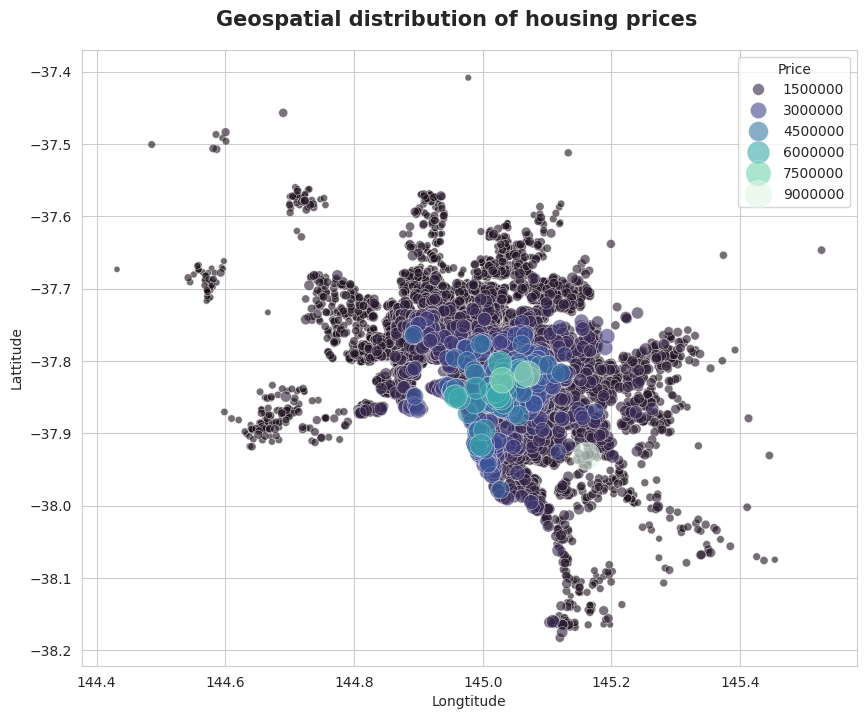

In [25]:
fig,ax=plt.subplots(figsize=(10,8))
cmap = sns.color_palette("mako", as_cmap=True)
fig.suptitle("Geospatial distribution of housing prices",y=0.93,
             fontweight="bold",fontsize=15,horizontalalignment="center")
ax=sns.scatterplot(y="Lattitude",x="Longtitude",
                  hue="Price",data=df.sort_values(by="Price",axis=0),
                  palette=cmap, size="Price",
                  sizes=(10,400),alpha=0.6,
                  )
norm=plt.Normalize(df["Price"].min(),df["Price"].max())

plt.show()

It is clear that the almost all high value properties are located near the city centre. Assuming that the coordinates are long: 145, lat: -37.82 (source: https://database.earth) we can use the distance from the city centre as a valuable regressor.

In [26]:
df['CentreDistance'] = np.sqrt(((df['Lattitude'] - 37.82)**2 + (df['Longtitude'] - 145)**2))
df['CentreDistance']

0        75.619600
1        75.627900
2        75.629300
3        75.616900
4        75.627200
           ...    
13575    75.725805
13576    75.679367
13577    75.672824
13578    75.679156
13579    75.631968
Name: CentreDistance, Length: 13442, dtype: float64

### SIMPLE LINEAR REGRESSION MODELS

In [27]:
import statsmodels.formula.api as smf
slr_model = smf.ols(formula = 'Price~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea + Type + Regionname + YearBuilt + CentreDistance', data = df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     967.3
Date:                Sat, 11 Jan 2025   Prob (F-statistic):               0.00
Time:                        23:14:03   Log-Likelihood:            -1.9334e+05
No. Observations:               13442   AIC:                         3.867e+05
Df Residuals:                   13424   BIC:                         3.869e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                -6.701e+07   5.72e+06    -11.717      0.000   -7.82e+07   -5.58e+07
Type[T.t]                                -2.014e+05   1.47e+04    -13.686      0.000    -2.3e+05   -1.73e+05
Type[T.u]                                -3.688e+05   1.16e+04    -31.738      0.000   -3.92e+05   -3.46e+05
Regionname[T.Eastern Victoria]           -6.363e+05    6.3e+04    -10.105      0.000    -7.6e+05   -5.13e+05
Regionname[T.Northern Metropolitan]       4.227e+04   1.42e+04      2.969      0.003    1.44e+04    7.02e+04
Regionname[T.Northern Victoria]          -4.311e+05   7.24e+04     -5.953      0.000   -5.73e+05   -2.89e+05
Regionname[T.South-Eastern Metropolitan] -3.807e+05   2.79e+04    -13.660      0.000   -4.35e+05   -3.26e+05
Regionname[T.Southern Metropolitan]       3.329e+05   1.44e+04     23.192      0.000    3.05e+05    3.61e+05
Regionname[T.Western Metropolitan]       -1.327e+05   1.38e+04     -9.622      0.000    -1.6e+05   -1.06e+05
Regionname[T.Western Victoria]           -5.749e+05   7.67e+04     -7.493      0.000   -7.25e+05   -4.25e+05
Rooms                                     9.726e+04   5976.868     16.272      0.000    8.55e+04    1.09e+05
Propertycount                               -2.9193      0.903     -3.233      0.001      -4.689      -1.149
Bathroom                                  1.972e+05   7209.262     27.352      0.000    1.83e+05    2.11e+05
Car                                       1.705e+04   4301.046      3.965      0.000    8622.267    2.55e+04
Landsize                                    25.5985      5.144      4.976      0.000      15.516      35.681
BuildingArea                              2397.5861     87.227     27.487      0.000    2226.608    2568.564
YearBuilt                                -4092.6477    140.064    -29.220      0.000   -4367.193   -3818.103
CentreDistance                            9.944e+05   7.52e+04     13.217      0.000    8.47e+05    1.14e+06
==============================================================================
Omnibus:                     8375.152   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           272917.479
Skew:                           2.473   Prob(JB):                         0.00
Kurtosis:                      24.513   Cond. No.                     1.37e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In order to see if a linear regression model is a good fit, we need to check the linearity assumption with a fitted values vs residuals plot.

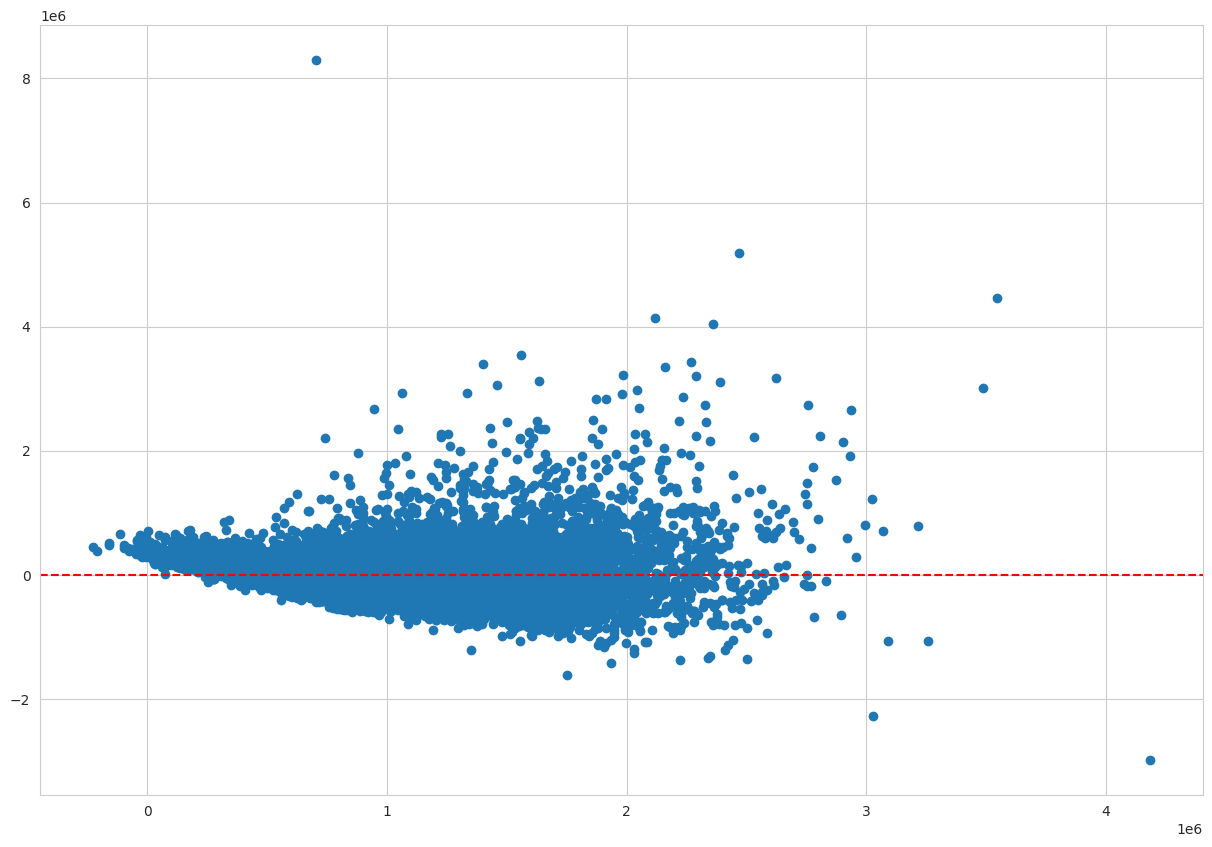

In [28]:
plt.figure(figsize=(15,10))
plt.scatter(slr_model.fittedvalues, slr_model.resid)
plt.axhline(y=0,color='r',linestyle = '--')
plt.show()

The points are not perfectly and evenly scattered in the first part of the plot, the linearity assumption isn't fully met, but the result isn't bad.

### PREDICTIVE MODEL

In order to build the final predicting model we decided to create dummy variables for the categorical explanatory variables and then perform a train-test split on the dataset.

In [29]:
df_def = pd.get_dummies(df, drop_first=True, dtype = int)
df_def

,Rooms,Price,Propertycount,Bathroom,Bedroom2,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,CentreDistance,Type_t,Type_u,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
0,2,1480000.0,4019.0,1.0,2.0,1.0,202.0,139.617708,1970.0,-37.79960,...,75.619600,0,0,0,1,0,0,0,0,0
1,2,1035000.0,4019.0,1.0,2.0,0.0,156.0,79.000000,1900.0,-37.80790,...,75.627900,0,0,0,1,0,0,0,0,0
2,3,1465000.0,4019.0,2.0,3.0,0.0,134.0,150.000000,1900.0,-37.80930,...,75.629300,0,0,0,1,0,0,0,0,0
3,3,850000.0,4019.0,2.0,3.0,1.0,94.0,139.617708,1970.0,-37.79690,...,75.616900,0,0,0,1,0,0,0,0,0
4,4,1600000.0,4019.0,1.0,3.0,2.0,120.0,142.000000,2014.0,-37.80720,...,75.627200,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,4,1245000.0,7392.0,2.0,4.0,2.0,652.0,139.617708,1981.0,-37.90562,...,75.725805,0,0,0,0,0,1,0,0,0
13576,3,1031000.0,6380.0,2.0,3.0,2.0,333.0,133.000000,1995.0,-37.85927,...,75.679367,0,0,0,0,0,0,0,1,0
13577,3,1170000.0,6380.0,2.0,3.0,4.0,436.0,139.617708,1997.0,-37.85274,...,75.672824,0,0,0,0,0,0,0,1,0
13578,4,2500000.0,6380.0,1.0,4.0,5.0,866.0,157.000000,1920.0,-37.85908,...,75.679156,0,0,0,0,0,0,0,1,0


In [30]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_def, test_size = 0.2, random_state = 100)
df_train

,Rooms,Price,Propertycount,Bathroom,Bedroom2,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,CentreDistance,Type_t,Type_u,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
7415,3,501000.0,1119.0,1.0,3.0,1.0,255.0,132.000000,1991.0,-37.72430,...,75.544442,0,1,0,0,0,0,0,1,0
11353,2,785000.0,1308.0,1.0,2.0,2.0,145.0,139.617708,1970.0,-37.73993,...,75.559993,0,1,0,0,0,0,0,1,0
1723,3,1170000.0,7822.0,1.0,2.0,2.0,461.0,139.617708,1970.0,-37.89880,...,75.718818,0,0,0,0,0,0,1,0,0
11860,3,485000.0,16166.0,1.0,3.0,1.0,633.0,88.000000,1960.0,-37.89444,...,75.715222,0,0,0,0,0,0,0,1,0
10078,5,1425000.0,4280.0,3.0,5.0,3.0,842.0,139.617708,1970.0,-37.85841,...,75.678630,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2,1455000.0,3280.0,1.0,2.0,0.0,159.0,139.617708,1970.0,-37.84500,...,75.665014,0,0,0,0,0,0,1,0,0
12188,2,300000.0,3296.0,1.0,2.0,1.0,0.0,66.320000,1980.0,-37.69815,...,75.518245,0,1,0,0,0,0,0,1,0
8083,3,895000.0,17496.0,2.0,3.0,3.0,0.0,139.617708,1970.0,-37.80950,...,75.629506,0,1,0,1,0,0,0,0,0
6976,4,2800000.0,6482.0,1.0,4.0,2.0,764.0,171.000000,1940.0,-37.83740,...,75.657416,0,0,0,0,0,0,1,0,0


To improve the slope's interpretability we can z-score scale our training dataset using the training dataset columns means and standard deviation:

In [31]:
from sklearn.preprocessing import StandardScaler
scaler_training = StandardScaler()
scaled_expl_var = scaler_training.fit_transform(df_train[['Rooms', 'Propertycount', 'Bathroom', 'Bedroom2', 'Car', 'Landsize','BuildingArea', 'YearBuilt', 'CentreDistance']])
df_train[['Rooms', 'Propertycount', 'Bathroom', 'Bedroom2', 'Car', 'Landsize','BuildingArea','YearBuilt', 'CentreDistance']] = scaled_expl_var
df_train.head()

,Rooms,Price,Propertycount,Bathroom,Bedroom2,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,CentreDistance,Type_t,Type_u,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
7415,0.074116,501000.0,-1.441183,-0.773663,0.099674,-0.623592,-0.317870,-0.142123,0.855932,-37.72430,...,-1.070565,0,1,0,0,0,0,0,1,0
11353,-0.969038,785000.0,-1.398414,-0.773663,-0.943945,0.415535,-0.463100,0.004750,0.108451,-37.73993,...,-0.874413,0,1,0,0,0,0,0,1,0
1723,0.074116,1170000.0,0.075631,-0.773663,-0.943945,0.415535,-0.045894,0.004750,0.108451,-37.89880,...,1.129026,0,0,0,0,0,0,1,0,0
11860,0.074116,485000.0,1.963784,-0.773663,0.099674,-0.623592,0.181192,-0.990466,-0.247492,-37.89444,...,1.083669,0,0,0,0,0,0,0,1,0
10078,2.160425,1425000.0,-0.725884,2.128046,2.186913,1.454661,0.457129,0.004750,0.108451,-37.85841,...,0.622094,0,0,0,0,0,0,0,0,0


In [32]:
scaled_expl_var2 = scaler_training.transform(df_test[['Rooms', 'Propertycount', 'Bathroom', 'Bedroom2', 'Car', 'Landsize','BuildingArea', 'YearBuilt', 'CentreDistance']])
df_test[['Rooms', 'Propertycount', 'Bathroom', 'Bedroom2', 'Car', 'Landsize','BuildingArea', 'YearBuilt', 'CentreDistance']] = scaled_expl_var2
df_test.head()

,Rooms,Price,Propertycount,Bathroom,Bedroom2,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,CentreDistance,Type_t,Type_u,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
2149,1.117270,1200000.0,0.348535,-0.773663,1.143294,0.415535,0.212879,0.004750,0.108451,-37.78560,...,-0.297541,0,0,0,0,0,0,0,0,0
7298,0.074116,625000.0,-1.199959,-0.773663,0.099674,-1.662718,0.263049,0.004750,0.108451,-37.78080,...,-0.356918,0,0,0,0,0,0,0,1,0
10859,0.074116,778000.0,-0.091823,0.677191,0.099674,0.415535,-0.250536,0.004750,1.603412,-37.85605,...,0.594551,0,0,0,0,0,0,0,0,0
11268,0.074116,451500.0,-0.533086,-0.773663,0.099674,-0.623592,-0.416890,-0.990466,-0.069520,-37.83648,...,0.344257,0,1,0,0,0,0,0,1,0
12431,0.074116,1170000.0,-1.194075,-0.773663,0.099674,-0.623592,-0.300707,-0.257806,0.962715,-37.77530,...,-0.428982,0,0,0,1,0,0,0,0,0


In [33]:
df_train.columns = df_train.columns.str.replace(" ", "_").str.replace("-", "_")
df_test.columns = df_test.columns.str.replace(" ", "_").str.replace("-", "_")


In [34]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt + CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     779.8
Date:                Sat, 11 Jan 2025   Prob (F-statistic):               0.00
Time:                        23:14:04   Log-Likelihood:            -1.5469e+05
No. Observations:               10753   AIC:                         3.094e+05
Df Residuals:                   10735   BIC:                         3.095e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              1.089e+06   1.34e+04     81.283      0.000    1.06e+06    1.12e+06
Rooms                                   9.37e+04   6408.439     14.621      0.000    8.11e+04    1.06e+05
Propertycount                         -1.311e+04   4439.302     -2.953      0.003   -2.18e+04   -4405.640
Bathroom                               1.394e+05   5558.350     25.071      0.000    1.28e+05     1.5e+05
Car                                    1.562e+04   4637.208      3.369      0.001    6530.972    2.47e+04
Landsize                               1.968e+04   4202.244      4.684      0.000    1.14e+04    2.79e+04
BuildingArea                           1.237e+05   5044.060     24.519      0.000    1.14e+05    1.34e+05
Type_t                                -1.998e+05   1.66e+04    -12.037      0.000   -2.32e+05   -1.67e+05
Type_u                                 -3.64e+05    1.3e+04    -27.931      0.000    -3.9e+05   -3.38e+05
YearBuilt                             -1.231e+05   4567.287    -26.957      0.000   -1.32e+05   -1.14e+05
CentreDistance                         7.269e+04   6674.965     10.890      0.000    5.96e+04    8.58e+04
Regionname_Eastern_Victoria           -6.419e+05   6.99e+04     -9.177      0.000   -7.79e+05   -5.05e+05
Regionname_Northern_Metropolitan       3.708e+04    1.6e+04      2.311      0.021    5633.306    6.85e+04
Regionname_Northern_Victoria          -4.456e+05   7.82e+04     -5.695      0.000   -5.99e+05   -2.92e+05
Regionname_South_Eastern_Metropolitan -3.587e+05   3.15e+04    -11.401      0.000    -4.2e+05   -2.97e+05
Regionname_Southern_Metropolitan        3.37e+05   1.62e+04     20.796      0.000    3.05e+05    3.69e+05
Regionname_Western_Metropolitan       -1.372e+05   1.55e+04     -8.832      0.000   -1.68e+05   -1.07e+05
Regionname_Western_Victoria           -5.522e+05    8.7e+04     -6.348      0.000   -7.23e+05   -3.82e+05
==============================================================================
Omnibus:                     7036.509   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           265557.545
Skew:                           2.608   Prob(JB):                         0.00
Kurtosis:                      26.780   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### The test dataset R^2 is:

In [35]:
from sklearn.metrics import r2_score
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5411173933290108

# BACKWARD SELECTION ALGORITHM

### Our goal is to find the model with the highest test R^2, so we use a backward elimination algorithm starting from our regression model with all the explanatory variables:

In [36]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
original_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = original_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5411173933290108

In [37]:
formula = """
Price ~ Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5323282746811465

In [38]:
formula = """
Price ~ Rooms  + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5407968554607917

In [39]:
formula = """
Price ~ Rooms + Propertycount  + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5210813175798623

In [40]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5404191144811235

In [41]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car  + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5406672803595822

In [42]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize  
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5148464604437104

In [43]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
 + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5337549920731968

In [44]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t  + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5019383647652712

In [45]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5411173933290108

In [46]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u  + YearBuilt +  CentreDistance
+ Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5380075574395073

In [47]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5405192617370137

In [48]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
 + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5406281766831802

In [49]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria 
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5315674778173837

In [50]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
 + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5228874699211175

In [51]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan 
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.538723401465562

In [52]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria + Regionname_Northern_Metropolitan
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan

"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5384048588642174

Currently the best model is:

In [53]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
current_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = current_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5405192617370137

In [54]:
formula = """
Price ~  Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5321252327852635

In [55]:
formula = """
Price ~ Rooms  + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5403994266937092

In [56]:
formula = """
Price ~ Rooms + Propertycount  + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5207069489962463

In [57]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5398885882273206

In [58]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car  + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5401595922055554

In [59]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize  
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5145423666075415

In [60]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
 + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5331577945613095

In [61]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t  + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5007337360333678

In [62]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5370781059618799

In [63]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
 + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.539769997613502

In [64]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria 
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.529719980499019

In [65]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
 + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5210718995093615

In [66]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan 
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5326740977046145

In [67]:
formula = """
Price ~ Rooms + Propertycount + Bathroom + Car + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan

"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5373925211576862

BEST CURRENT MODEL

In [68]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
current_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = current_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5398885882273206

In [69]:
formula = """
Price ~   Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5306266094408608

In [70]:
formula = """
Price ~ Rooms  + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5397810519303506

In [71]:
formula = """
Price ~ Rooms + Propertycount   + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5189734167410933

In [72]:
formula = """
Price ~ Rooms + Propertycount + Bathroom   + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.539402648329204

In [73]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize  
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5135290492656954

In [74]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
 + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5322521815679617

In [75]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t  + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.4983877728677647

In [76]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.53655235030926

In [77]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
 + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5391121393673015

In [78]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria 
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5294052737087762

In [79]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
 + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5199040693825319

In [80]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan 
+ Regionname_Western_Victoria
"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5322786704594544

In [81]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan

"""
slr_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = slr_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5368278699612143

THE MODEL WITH THE HIGHEST TEST R^2 IS:

In [82]:
formula = """
Price ~ Rooms + Propertycount + Bathroom  + Landsize + BuildingArea 
+ Type_t + Type_u + YearBuilt +  CentreDistance
+ Regionname_Eastern_Victoria 
+ Regionname_Northern_Victoria + Regionname_South_Eastern_Metropolitan
+ Regionname_Southern_Metropolitan + Regionname_Western_Metropolitan
+ Regionname_Western_Victoria
"""
current_model = smf.ols(formula=formula, data=df_train).fit()
y_test = df_test['Price']
y_pred_test = current_model.predict(df_test)
r2_score(y_test,y_pred_test)

0.5398885882273206

In [83]:
current_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     881.6
Date:                Sat, 11 Jan 2025   Prob (F-statistic):               0.00
Time:                        23:14:10   Log-Likelihood:            -1.5469e+05
No. Observations:               10753   AIC:                         3.094e+05
Df Residuals:                   10737   BIC:                         3.095e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              1.113e+06   8464.695    131.528      0.000     1.1e+06    1.13e+06
Rooms                                  9.632e+04   6261.950     15.382      0.000     8.4e+04    1.09e+05
Propertycount                          -1.02e+04   4302.576     -2.371      0.018   -1.86e+04   -1767.405
Bathroom                               1.408e+05   5542.175     25.403      0.000     1.3e+05    1.52e+05
Landsize                               2.034e+04   4187.452      4.856      0.000    1.21e+04    2.85e+04
BuildingArea                            1.24e+05   5042.689     24.591      0.000    1.14e+05    1.34e+05
Type_t                                -2.018e+05   1.66e+04    -12.175      0.000   -2.34e+05   -1.69e+05
Type_u                                -3.683e+05    1.3e+04    -28.350      0.000   -3.94e+05   -3.43e+05
YearBuilt                             -1.222e+05   4522.590    -27.014      0.000   -1.31e+05   -1.13e+05
CentreDistance                         6.842e+04   6484.806     10.551      0.000    5.57e+04    8.11e+04
Regionname_Eastern_Victoria           -6.545e+05   6.96e+04     -9.398      0.000   -7.91e+05   -5.18e+05
Regionname_Northern_Victoria          -4.775e+05   7.72e+04     -6.184      0.000   -6.29e+05   -3.26e+05
Regionname_South_Eastern_Metropolitan -3.664e+05   3.09e+04    -11.873      0.000   -4.27e+05   -3.06e+05
Regionname_Southern_Metropolitan       3.171e+05   1.32e+04     23.945      0.000    2.91e+05    3.43e+05
Regionname_Western_Metropolitan       -1.593e+05   1.16e+04    -13.777      0.000   -1.82e+05   -1.37e+05
Regionname_Western_Victoria           -5.803e+05   8.63e+04     -6.725      0.000   -7.49e+05   -4.11e+05
==============================================================================
Omnibus:                     7051.032   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           264117.282
Skew:                           2.619   Prob(JB):                         0.00
Kurtosis:                      26.708   Cond. No.                         30.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""